In [ ]:
import pandas as pd
import numpy as np

from tsfresh.feature_extraction import extract_features, EfficientFCParameters
from tsfresh.utilities.dataframe_functions import impute
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import matplotlib.pyplot as plt

from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, balanced_accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils.class_weight import compute_sample_weight
from tsfresh.feature_selection import select_features
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate

from pyts.transformation import BOSS
from pyts.datasets import load_gunpoint

from catboost import CatBoostClassifier

In [2]:
# # Toy dataset to understand the shape needed
# X_train, _, y_train, _ = load_gunpoint(return_X_y=True)
# X_train.shape
# plt.plot(X_train[0,:]);
# plt.plot(X_train[1,:]);
# plt.plot(X_train[23,:]);
# X_train.shape

In [3]:
raw_data_prep_dir = '../raw_data/pads-parkinsons-disease-smartwatch-dataset-1.0.0/preprocessed/'

In [20]:
file_list = pd.read_csv(raw_data_prep_dir  + "file_list.csv")
file_list

,resource_type,id,study_id,condition,disease_comment,age_at_diagnosis,age,height,weight,gender,handedness,appearance_in_kinship,appearance_in_first_grade_kinship,effect_of_alcohol_on_tremor,label
0,patient,1,PADS,Healthy,-,56,56,173,78,male,right,True,True,Unknown,0
1,patient,2,PADS,Other Movement Disorders,Left-Sided resting tremor and hypokinesia with...,69,81,193,104,male,right,False,NaN,No effect,2
2,patient,3,PADS,Healthy,-,45,45,170,78,female,right,False,NaN,Unknown,0
3,patient,4,PADS,Parkinson's,IPS akinetic-rigid type,63,67,161,90,female,right,False,NaN,No effect,1
4,patient,5,PADS,Parkinson's,IPS tremordominant type,65,75,172,86,male,left,False,NaN,Unknown,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
464,patient,465,PADS,Parkinson's,IPS mixed type,62,65,175,80,male,right,True,False,No effect,1
465,patient,466,PADS,Healthy,-,84,84,172,74,female,right,True,True,No effect,0
466,patient,467,PADS,Parkinson's,"Essential Tremor, starting IPS tremordominant ...",55,57,190,100,male,right,False,NaN,Improvement,1
467,patient,468,PADS,Parkinson's,IPS mixed type,73,76,198,118,male,right,False,NaN,No effect,1


In [5]:
time_data = []
y = []
X_to_split = []
for idx, subject_idx in enumerate(file_list['id']):
    file_name = raw_data_prep_dir + f'movement/{subject_idx:03d}_ml.bin'
    time_idx_data = np.fromfile(file_name, dtype=np.float32).reshape((-1, 976))
    time_data.append(time_idx_data)
    y_idx = file_list[file_list['id']==subject_idx].label.values
    X_id = idx
    y.append(y_idx)
    X_to_split.append(X_id)

X_to_split = np.array(X_to_split)
y = np.array(y).flatten()
time_data = np.array(time_data)
print(time_data.shape)
time_data.shape[0]
range(time_data.shape[0])

(469, 132, 976)


range(0, 469)

In [57]:
#train test split
X_train_idx, X_test_idx, y_train, y_test = train_test_split(X_to_split, y, test_size=0.20, random_state=23, stratify = y)
X_train = time_data[X_train_idx]
X_test = time_data[X_test_idx]
print(len(X_train), len(X_test))
print(len(y_train), len(y_test))
X_train.shape

375 94
375 94


(375, 132, 976)

In [58]:
def channel_wise_boss(time_data, strategy = 'quantile', word_size = 2, window_size = 30, window_step = 2, n_bins = 4):
    boss = BOSS(strategy = strategy,
                word_size = word_size,
                window_size = window_size,
                window_step = window_step,
                n_bins = n_bins)
    boss_output = []
    for c_idx in range(time_data.shape[1]):
        c_data = time_data[:,c_idx,:]
        c_feat = boss.fit(c_data)
        print(c_feat)
        boss_output.append(c_feat)
    return boss_output

In [59]:
boss_output = channel_wise_boss(X_train, word_size = 2, window_size = 10, window_step = 2, n_bins = 4)

BOSS(window_step=2, word_size=2)
BOSS(window_step=2, word_size=2)
BOSS(window_step=2, word_size=2)
BOSS(window_step=2, word_size=2)
BOSS(window_step=2, word_size=2)
BOSS(window_step=2, word_size=2)
BOSS(window_step=2, word_size=2)
BOSS(window_step=2, word_size=2)
BOSS(window_step=2, word_size=2)
BOSS(window_step=2, word_size=2)
BOSS(window_step=2, word_size=2)
BOSS(window_step=2, word_size=2)
BOSS(window_step=2, word_size=2)
BOSS(window_step=2, word_size=2)
BOSS(window_step=2, word_size=2)
BOSS(window_step=2, word_size=2)
BOSS(window_step=2, word_size=2)
BOSS(window_step=2, word_size=2)
BOSS(window_step=2, word_size=2)
BOSS(window_step=2, word_size=2)
BOSS(window_step=2, word_size=2)
BOSS(window_step=2, word_size=2)
BOSS(window_step=2, word_size=2)
BOSS(window_step=2, word_size=2)
BOSS(window_step=2, word_size=2)
BOSS(window_step=2, word_size=2)
BOSS(window_step=2, word_size=2)
BOSS(window_step=2, word_size=2)
BOSS(window_step=2, word_size=2)
BOSS(window_step=2, word_size=2)
BOSS(windo

In [60]:
print(len(boss_output))
boss_output[2]

(X_train[1, 1, :]).reshape(1,-1).shape
len(X_train)

132


375

In [61]:
def boss_transform_data(boss_output,X):
    X_boss = []
    for s_idx in range(X.shape[0]):
        for c_idx in range(X.shape[1]):
            channel_boss= boss_output[c_idx]
            boss_features = channel_boss.transform(X[s_idx,c_idx,:].reshape(1,-1))
            X_boss.append(boss_features.toarray())
    print(len(boss_features.toarray()))
    n_feat = len(boss_features.toarray()[0])
    X_boss_reshape = np.array(X_boss).reshape(len(X),X.shape[1]*n_feat)
    return X_boss_reshape

In [62]:
X_boss_train = boss_transform_data(boss_output, X_train)

1


In [63]:
test = boss_output[1].transform(X_train[1,1,:].reshape(1,-1))
len(test.toarray()[0])

16

In [64]:
X_boss_test = boss_transform_data(boss_output, X_test)
#X_boss_test_scaled = s_scaler.transform(X_boss_test)

1


In [65]:
pd.DataFrame(X_boss_train)

,0,1,2,3,4,5,6,7,8,9,...,2102,2103,2104,2105,2106,2107,2108,2109,2110,2111
0,0,0,0,0,0,92,78,0,0,19,...,22,28,28,26,21,25,25,8,11,10
1,1,2,2,1,1,73,67,6,5,37,...,26,16,15,38,27,8,10,14,7,4
2,0,1,1,2,5,45,49,5,6,48,...,13,22,18,6,7,19,31,22,21,20
3,0,0,0,0,0,70,61,0,0,56,...,14,37,44,20,14,18,31,8,4,7
4,0,0,0,0,0,97,92,0,0,10,...,38,16,21,44,34,13,5,9,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370,0,0,0,0,0,97,86,0,0,19,...,39,33,29,35,30,17,9,12,14,4
371,0,0,0,0,0,100,96,0,0,16,...,6,15,13,17,11,10,27,36,27,16
372,0,0,0,0,0,88,83,0,0,24,...,12,22,20,13,12,22,24,19,19,14
373,0,0,0,0,0,74,71,0,0,37,...,24,14,15,27,22,9,19,25,17,6


In [ ]:
#s_scaler = StandardScaler()
#s_scaler.fit(X_boss_train)
#X_boss_train_scaled = s_scaler.transform(X_boss_train)

In [66]:
xgb = XGBClassifier()

sample_weights = compute_sample_weight(class_weight="balanced", y=y_train)

xgb.fit(X_boss_train, y_train, sample_weight=sample_weights)

,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [67]:
y_pred_xgb  = xgb.predict(X_boss_test)

In [68]:
xgb_accuracy = balanced_accuracy_score(y_test, y_pred_xgb)
f'xgb_accuracy: {xgb_accuracy}'

'xgb_accuracy: 0.6489130434782608'

In [69]:
cat_model = CatBoostClassifier(iterations = 2000,
                               learning_rate = 0.05,
                               depth = 7)

In [70]:
cat_model.fit(X_boss_train,y_train,
              eval_set = (X_boss_test, y_test),
              use_best_model = True,
              sample_weight = sample_weights)

0:	learn: 1.0809058	test: 1.0896868	best: 1.0896868 (0)	total: 76.2ms	remaining: 2m 32s
1:	learn: 1.0654676	test: 1.0849062	best: 1.0849062 (1)	total: 120ms	remaining: 1m 59s
2:	learn: 1.0507163	test: 1.0773403	best: 1.0773403 (2)	total: 159ms	remaining: 1m 45s
3:	learn: 1.0383316	test: 1.0741560	best: 1.0741560 (3)	total: 195ms	remaining: 1m 37s
4:	learn: 1.0270743	test: 1.0694865	best: 1.0694865 (4)	total: 229ms	remaining: 1m 31s
5:	learn: 1.0157723	test: 1.0644664	best: 1.0644664 (5)	total: 264ms	remaining: 1m 27s
6:	learn: 1.0020682	test: 1.0617164	best: 1.0617164 (6)	total: 299ms	remaining: 1m 25s
7:	learn: 0.9921836	test: 1.0595619	best: 1.0595619 (7)	total: 336ms	remaining: 1m 23s
8:	learn: 0.9818928	test: 1.0571145	best: 1.0571145 (8)	total: 372ms	remaining: 1m 22s
9:	learn: 0.9707524	test: 1.0518698	best: 1.0518698 (9)	total: 406ms	remaining: 1m 20s
10:	learn: 0.9593457	test: 1.0472231	best: 1.0472231 (10)	total: 442ms	remaining: 1m 19s
11:	learn: 0.9477535	test: 1.0403098	bes

In [1]:
y_pred_cat = cat_model.predict(X_boss_test)

NameError: name 'cat_model' is not defined

In [72]:
cat_accuracy = balanced_accuracy_score(y_test, y_pred_cat)
f'cat_accuracy: {cat_accuracy}'

'cat_accuracy: 0.657131093544137'

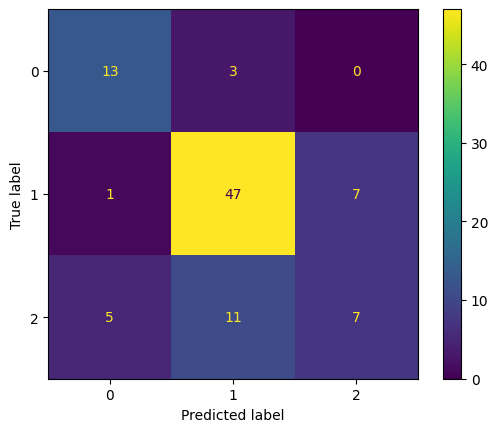

In [73]:
cm_cat = confusion_matrix(y_test,y_pred_cat)
disp_cm_cat  = ConfusionMatrixDisplay(cm_cat)
disp_cm_cat.plot();

In [ ]:
cat_model.select_features(X_boss_train, y_train, features_for_select=list(range(X_boss_train.shape[1])), train_final_model=True, eval_set=(X_boss_test, y_test), num_features_to_select=80)

NameError: name 'cat_model' is not defined

In [74]:
pca = PCA()

In [75]:
pca = PCA()
X_pca_train = pca.fit_transform(X= X_boss_train)
X_pca_test = pca.transform(X=X_boss_test)

In [76]:
np.array(X_pca_train)
X_pca_train.shape
X_pca_test.shape

(94, 375)

In [77]:
cat_model_pca = CatBoostClassifier(iterations = 2000,
                                    learning_rate = 0.05,
                                    depth = 7)

In [78]:
cat_model_pca.fit(X_pca_train, y_train,
                  eval_set = (X_pca_test, y_test),
                  use_best_model = True,
                  sample_weight=sample_weights)

0:	learn: 1.0917108	test: 1.0989170	best: 1.0989170 (0)	total: 48.7ms	remaining: 1m 37s
1:	learn: 1.0847108	test: 1.0992621	best: 1.0989170 (0)	total: 85.7ms	remaining: 1m 25s
2:	learn: 1.0729068	test: 1.0977348	best: 1.0977348 (2)	total: 121ms	remaining: 1m 20s
3:	learn: 1.0652178	test: 1.0982618	best: 1.0977348 (2)	total: 155ms	remaining: 1m 17s
4:	learn: 1.0555440	test: 1.0972147	best: 1.0972147 (4)	total: 189ms	remaining: 1m 15s
5:	learn: 1.0454922	test: 1.0962684	best: 1.0962684 (5)	total: 224ms	remaining: 1m 14s
6:	learn: 1.0344401	test: 1.0935821	best: 1.0935821 (6)	total: 257ms	remaining: 1m 13s
7:	learn: 1.0246888	test: 1.0923902	best: 1.0923902 (7)	total: 294ms	remaining: 1m 13s
8:	learn: 1.0183288	test: 1.0938946	best: 1.0923902 (7)	total: 327ms	remaining: 1m 12s
9:	learn: 1.0106407	test: 1.0924672	best: 1.0923902 (7)	total: 361ms	remaining: 1m 11s
10:	learn: 1.0030732	test: 1.0923391	best: 1.0923391 (10)	total: 395ms	remaining: 1m 11s
11:	learn: 0.9953689	test: 1.0917890	be

In [79]:
xgb_pca = XGBClassifier()

In [80]:
xgb_pca.fit(X_pca_train, y_train, sample_weight=sample_weights)

,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [81]:
y_pred_pca_xgb = xgb_pca.predict(X_pca_test)
y_pred_pca_xgb

array([1, 1, 0, 1, 2, 1, 1, 1, 2, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 2, 1, 0, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 0, 0,
       0, 2, 1, 1, 1, 1, 1, 2, 2, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 2, 1, 1, 1, 0, 1, 1, 2, 2, 1,
       0, 1, 2, 1, 1, 1])

In [82]:
y_pred_pca_cat = cat_model_pca.predict(X_pca_test)
y_pred_pca_cat

array([[1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [2],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
    

In [83]:
balanced_accuracy_score(y_test, y_pred_pca_xgb)

0.6296772068511198

In [84]:
balanced_accuracy_score(y_test, y_pred_pca_cat)

0.4604249011857708

In [2]:
sv_model_pca = SVC(kernel = 'rbf', class_weight = 'balanced', C = 1)

NameError: name 'SVC' is not defined

In [86]:
sv_model_pca.fit(X_pca_train, y_train)

,C,1
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,'balanced'
,verbose,False


In [87]:
y_pred_pca_sv = sv_model_pca.predict(X_pca_test)
balanced_accuracy_score(y_test, y_pred_pca_sv)

0.6781785243741765

In [ ]:
#sv_model.fit(X_boss_train, y_train)

,C,1
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,'balanced'
,verbose,False


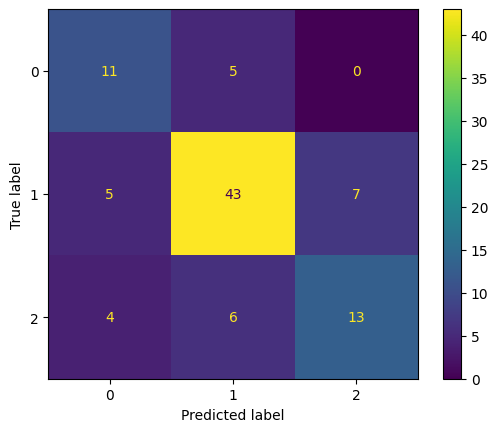

In [88]:
cm_pca_sv = confusion_matrix(y_test,y_pred_pca_sv)
disp_cm_sv  = ConfusionMatrixDisplay(cm_pca_sv)
disp_cm_sv.plot();